In [9]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# # Definir transformações e DataLoader
# class DataLoaderSetup:
#     def __init__(self, dataset_path, image_size=224, batch_size=32):
#         self.dataset_path = dataset_path
#         self.image_size = image_size
#         self.batch_size = batch_size

#     def get_transforms(self):
#         transformacoes_de_imagens = {
#             'treino': transforms.Compose([
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
#                 transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#                 transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ]),
#             'validacao': transforms.Compose([
#                 transforms.Resize(self.image_size),
#                 transforms.CenterCrop(self.image_size),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ])
#         }
#         return transformacoes_de_imagens

#     def load_data(self):
#         transformacoes = self.get_transforms()
#         pasta_treino = os.path.join(self.dataset_path, 'treino')
#         pasta_validacao = os.path.join(self.dataset_path, 'validacao')

#         data = {
#             'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes['treino']),
#             'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes['validacao'])
#         }
#         return data

#     def get_data_loaders(self):
#         data = self.load_data()
#         data_loader_treino = DataLoader(data['treino'], batch_size=self.batch_size, shuffle=True)
#         data_loader_validacao = DataLoader(data['validacao'], batch_size=self.batch_size, shuffle=True)
#         return data_loader_treino, data_loader_validacao, len(data['treino']), len(data['validacao']), len(data['treino'].classes)

# # Classe para o modelo
class CustomResNet50:
    def __init__(self, num_classes):
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def get_model(self):
        return self.model

# class Trainer:
#     def __init__(self, model, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience=5, nameModel='model.pt'):
#         self.model = model
#         self.data_loader_treino = data_loader_treino
#         self.data_loader_validacao = data_loader_validacao
#         self.num_imagens_treino = num_imagens_treino
#         self.num_imagens_validacao = num_imagens_validacao
#         self.device = device
#         self.funcao_erro = nn.CrossEntropyLoss()
#         self.otimizador = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-4)
#         self.scheduler = ReduceLROnPlateau(self.otimizador, mode='min', factor=0.1, patience=3, verbose=True)
#         self.patience = patience
#         self.nameModel = nameModel

#     def treinar_e_validar(self, epocas):
#         historico = []
#         melhor_acuracia = 0.0
#         early_stop_counter = 0

#         for epoca in range(epocas):
#             inicio_epoca = time.time()
#             print(f"\n\nÉpoca: {epoca + 1}/{epocas}")
#             erro_treino, acuracia_treino = self.executar_fase('treino')
#             erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

#             fim_epoca = time.time()
#             print(f"Época {epoca + 1}/{epocas}, Treino: Erro: {erro_treino:.4f}, Acurácia: {acuracia_treino * 100:.2f}%, "
#                   f"Validação: Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%, Tempo: {fim_epoca - inicio_epoca:.2f}s")

#             historico.append([erro_treino, erro_validacao, acuracia_treino, acuracia_validacao])
#             self.scheduler.step(erro_validacao)

#             # Early stopping
#             if acuracia_validacao > melhor_acuracia:
#                 melhor_acuracia = acuracia_validacao
#                 torch.save(self.model.state_dict(), self.nameModel)
#                 early_stop_counter = 0
#             else:
#                 early_stop_counter += 1

#             if early_stop_counter >= self.patience:
#                 print("Parando o treinamento devido ao early stopping.")
#                 break

#         # Calcular métricas finais
#         self.calcular_metricas(predicoes_validacao, labels_validacao)
#         return historico

#     def executar_fase(self, fase, return_predictions=False):
#         if fase == 'treino':
#             self.model.train()
#             data_loader = self.data_loader_treino
#             num_imagens = self.num_imagens_treino
#         else:
#             self.model.eval()
#             data_loader = self.data_loader_validacao
#             num_imagens = self.num_imagens_validacao

#         erro_total = 0.0
#         acuracia_total = 0.0
#         todas_predicoes = []
#         todas_labels = []

#         with torch.set_grad_enabled(fase == 'treino'):
#             for entradas, labels in data_loader:
#                 entradas, labels = entradas.to(self.device), labels.to(self.device)

#                 if fase == 'treino':
#                     self.otimizador.zero_grad()

#                 saidas = self.model(entradas)
#                 erro = self.funcao_erro(saidas, labels)

#                 if fase == 'treino':
#                     erro.backward()
#                     self.otimizador.step()

#                 erro_total += erro.item() * entradas.size(0)
#                 _, predicoes = torch.max(saidas, 1)
#                 acuracia_total += (predicoes == labels).sum().item()

#                 if return_predictions:
#                     todas_predicoes.extend(predicoes.cpu().numpy())
#                     todas_labels.extend(labels.cpu().numpy())

#         erro_medio = erro_total / num_imagens
#         acuracia_media = acuracia_total / num_imagens

#         if return_predictions:
#             return erro_medio, acuracia_media, todas_predicoes, todas_labels
#         else:
#             return erro_medio, acuracia_media

#     def calcular_metricas(self, predicoes, labels):
#         acuracia = accuracy_score(labels, predicoes)
#         precisao = precision_score(labels, predicoes, average='weighted')
#         recall = recall_score(labels, predicoes, average='weighted')
#         f1 = f1_score(labels, predicoes, average='weighted')

#         print("\nMétricas de Validação:")
#         print(f"Acurácia: {acuracia:.4f}")
#         print(f"Precisão: {precisao:.4f}")
#         print(f"Recall: {recall:.4f}")
#         print(f"F1-Score: {f1:.4f}")

#         print("\nRelatório de Classificação:")
#         print(classification_report(labels, predicoes))

#         self.plotar_matriz_confusao(labels, predicoes)

#     def plotar_matriz_confusao(self, labels, predicoes):
#         matriz_confusao = confusion_matrix(labels, predicoes)
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=self.data_loader_treino.dataset.classes, yticklabels=self.data_loader_treino.dataset.classes)
#         plt.ylabel('Classe Verdadeira')
#         plt.xlabel('Classe Prevista')
#         plt.title('Matriz de Confusão')
#         plt.show()


In [10]:
# Função para avaliar o modelo
def avaliar_modelo(modelo, data_loader, device):
    modelo.to(device)
    modelo.eval()  # Colocar o modelo em modo de avaliação
    todas_predicoes = []
    todas_labels = []

    with torch.no_grad():
        for entradas, labels in data_loader:
            entradas, labels = entradas.to(device), labels.to(device)
            saidas = modelo(entradas)
            _, predicoes = torch.max(saidas, 1)

            todas_predicoes.extend(predicoes.cpu().numpy())
            todas_labels.extend(labels.cpu().numpy())

    # Converter listas para arrays numpy
    todas_predicoes = np.array(todas_predicoes)
    todas_labels = np.array(todas_labels)

    # Calcular acurácia
    acuracia = accuracy_score(todas_labels, todas_predicoes)

    # Calcular F1-score (média macro para considerar cada classe igualmente)
    f1 = f1_score(todas_labels, todas_predicoes, average='macro')

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(todas_labels, todas_predicoes)

    return acuracia, f1, matriz_confusao

In [11]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(matriz_confusao, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

In [12]:
dataset = r'../data/affectnet/processed/imagens_processed'
pasta_teste = os.path.join(dataset, 'treino')
image_size = 224
# Transformações para as imagens de teste
transformacoes_de_imagens = { 
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Criação dos datasets
data = {
    'teste': datasets.ImageFolder(root=pasta_teste, transform=transformacoes_de_imagens['teste'])
}
numero_de_classes = len(data['teste'].classes)  # Definir número de classes dinamicamente
print(f'Número de classes: {numero_de_classes}')


# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(num_classes=numero_de_classes)

# Carregar os pesos salvos do modelo
# Carregar os pesos salvos do modelo com mapeamento para CPU
estado_do_modelo = torch.load('./affectnet.pt')  # Mapeia para CPU
modelo_treinado.get_model().load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo


# Colocar o modelo em modo de avaliação
modelo_treinado.get_model().eval()

# Carregar os pesos salvos do modelo com mapeamento para CPU
# estado_do_modelo = torch.load('../models/model2affectnet.pt.pt', map_location=torch.device('cpu'))  # Mapeia para CPU

# # Remover o prefixo 'resnet.' das chaves do estado
# from collections import OrderedDict
# estado_do_modelo_corrigido = OrderedDict()
# for chave, valor in estado_do_modelo.items():
#     nova_chave = chave.replace("resnet.", "")  # Remover o prefixo 'resnet.'
#     estado_do_modelo_corrigido[nova_chave] = valor

# # Carregar os pesos corrigidos no modelo
# modelo_treinado.get_model().load_state_dict(estado_do_modelo_corrigido)

# # Colocar o modelo em modo de avaliação
# modelo_treinado.get_model().eval()


bs = 32
# DataLoader para dados de teste
data_loader_teste = DataLoader(data['teste'], batch_size=bs, shuffle=False)

# Avaliar o modelo com os dados de teste
acuracia_teste, f1_teste, matriz_confusao = avaliar_modelo(modelo_treinado.get_model(), data_loader_teste, device)

# Imprimir resultados
print(f"Acurácia no teste: {acuracia_teste * 100:.2f}%")
print(f"F1-Score no teste: {f1_teste:.4f}")

# Mapear os índices com os nomes das classes
indice_para_classe = {v: k for k, v in data['teste'].class_to_idx.items()}
classes = [indice_para_classe[i] for i in range(numero_de_classes)]

# Plotar a matriz de confusão
plotar_matriz_confusao(matriz_confusao, classes)

Número de classes: 8


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_17416\1177974043.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 
	Unexpected key(s) in state_dict: "resnet50.conv1.weight", "resnet50.bn1.weight", "resnet50.bn1.bias", "resnet50.bn1.running_mean", "resnet50.bn1.running_var", "resnet50.bn1.num_batches_tracked", "resnet50.layer1.0.conv1.weight", "resnet50.layer1.0.bn1.weight", "resnet50.layer1.0.bn1.bias", "resnet50.layer1.0.bn1.running_mean", "resnet50.layer1.0.bn1.running_var", "resnet50.layer1.0.bn1.num_batches_tracked", "resnet50.layer1.0.conv2.weight", "resnet50.layer1.0.bn2.weight", "resnet50.layer1.0.bn2.bias", "resnet50.layer1.0.bn2.running_mean", "resnet50.layer1.0.bn2.running_var", "resnet50.layer1.0.bn2.num_batches_tracked", "resnet50.layer1.0.conv3.weight", "resnet50.layer1.0.bn3.weight", "resnet50.layer1.0.bn3.bias", "resnet50.layer1.0.bn3.running_mean", "resnet50.layer1.0.bn3.running_var", "resnet50.layer1.0.bn3.num_batches_tracked", "resnet50.layer1.0.downsample.0.weight", "resnet50.layer1.0.downsample.1.weight", "resnet50.layer1.0.downsample.1.bias", "resnet50.layer1.0.downsample.1.running_mean", "resnet50.layer1.0.downsample.1.running_var", "resnet50.layer1.0.downsample.1.num_batches_tracked", "resnet50.layer1.1.conv1.weight", "resnet50.layer1.1.bn1.weight", "resnet50.layer1.1.bn1.bias", "resnet50.layer1.1.bn1.running_mean", "resnet50.layer1.1.bn1.running_var", "resnet50.layer1.1.bn1.num_batches_tracked", "resnet50.layer1.1.conv2.weight", "resnet50.layer1.1.bn2.weight", "resnet50.layer1.1.bn2.bias", "resnet50.layer1.1.bn2.running_mean", "resnet50.layer1.1.bn2.running_var", "resnet50.layer1.1.bn2.num_batches_tracked", "resnet50.layer1.1.conv3.weight", "resnet50.layer1.1.bn3.weight", "resnet50.layer1.1.bn3.bias", "resnet50.layer1.1.bn3.running_mean", "resnet50.layer1.1.bn3.running_var", "resnet50.layer1.1.bn3.num_batches_tracked", "resnet50.layer1.2.conv1.weight", "resnet50.layer1.2.bn1.weight", "resnet50.layer1.2.bn1.bias", "resnet50.layer1.2.bn1.running_mean", "resnet50.layer1.2.bn1.running_var", "resnet50.layer1.2.bn1.num_batches_tracked", "resnet50.layer1.2.conv2.weight", "resnet50.layer1.2.bn2.weight", "resnet50.layer1.2.bn2.bias", "resnet50.layer1.2.bn2.running_mean", "resnet50.layer1.2.bn2.running_var", "resnet50.layer1.2.bn2.num_batches_tracked", "resnet50.layer1.2.conv3.weight", "resnet50.layer1.2.bn3.weight", "resnet50.layer1.2.bn3.bias", "resnet50.layer1.2.bn3.running_mean", "resnet50.layer1.2.bn3.running_var", "resnet50.layer1.2.bn3.num_batches_tracked", "resnet50.layer2.0.conv1.weight", "resnet50.layer2.0.bn1.weight", "resnet50.layer2.0.bn1.bias", "resnet50.layer2.0.bn1.running_mean", "resnet50.layer2.0.bn1.running_var", "resnet50.layer2.0.bn1.num_batches_tracked", "resnet50.layer2.0.conv2.weight", "resnet50.layer2.0.bn2.weight", "resnet50.layer2.0.bn2.bias", "resnet50.layer2.0.bn2.running_mean", "resnet50.layer2.0.bn2.running_var", "resnet50.layer2.0.bn2.num_batches_tracked", "resnet50.layer2.0.conv3.weight", "resnet50.layer2.0.bn3.weight", "resnet50.layer2.0.bn3.bias", "resnet50.layer2.0.bn3.running_mean", "resnet50.layer2.0.bn3.running_var", "resnet50.layer2.0.bn3.num_batches_tracked", "resnet50.layer2.0.downsample.0.weight", "resnet50.layer2.0.downsample.1.weight", "resnet50.layer2.0.downsample.1.bias", "resnet50.layer2.0.downsample.1.running_mean", "resnet50.layer2.0.downsample.1.running_var", "resnet50.layer2.0.downsample.1.num_batches_tracked", "resnet50.layer2.1.conv1.weight", "resnet50.layer2.1.bn1.weight", "resnet50.layer2.1.bn1.bias", "resnet50.layer2.1.bn1.running_mean", "resnet50.layer2.1.bn1.running_var", "resnet50.layer2.1.bn1.num_batches_tracked", "resnet50.layer2.1.conv2.weight", "resnet50.layer2.1.bn2.weight", "resnet50.layer2.1.bn2.bias", "resnet50.layer2.1.bn2.running_mean", "resnet50.layer2.1.bn2.running_var", "resnet50.layer2.1.bn2.num_batches_tracked", "resnet50.layer2.1.conv3.weight", "resnet50.layer2.1.bn3.weight", "resnet50.layer2.1.bn3.bias", "resnet50.layer2.1.bn3.running_mean", "resnet50.layer2.1.bn3.running_var", "resnet50.layer2.1.bn3.num_batches_tracked", "resnet50.layer2.2.conv1.weight", "resnet50.layer2.2.bn1.weight", "resnet50.layer2.2.bn1.bias", "resnet50.layer2.2.bn1.running_mean", "resnet50.layer2.2.bn1.running_var", "resnet50.layer2.2.bn1.num_batches_tracked", "resnet50.layer2.2.conv2.weight", "resnet50.layer2.2.bn2.weight", "resnet50.layer2.2.bn2.bias", "resnet50.layer2.2.bn2.running_mean", "resnet50.layer2.2.bn2.running_var", "resnet50.layer2.2.bn2.num_batches_tracked", "resnet50.layer2.2.conv3.weight", "resnet50.layer2.2.bn3.weight", "resnet50.layer2.2.bn3.bias", "resnet50.layer2.2.bn3.running_mean", "resnet50.layer2.2.bn3.running_var", "resnet50.layer2.2.bn3.num_batches_tracked", "resnet50.layer2.3.conv1.weight", "resnet50.layer2.3.bn1.weight", "resnet50.layer2.3.bn1.bias", "resnet50.layer2.3.bn1.running_mean", "resnet50.layer2.3.bn1.running_var", "resnet50.layer2.3.bn1.num_batches_tracked", "resnet50.layer2.3.conv2.weight", "resnet50.layer2.3.bn2.weight", "resnet50.layer2.3.bn2.bias", "resnet50.layer2.3.bn2.running_mean", "resnet50.layer2.3.bn2.running_var", "resnet50.layer2.3.bn2.num_batches_tracked", "resnet50.layer2.3.conv3.weight", "resnet50.layer2.3.bn3.weight", "resnet50.layer2.3.bn3.bias", "resnet50.layer2.3.bn3.running_mean", "resnet50.layer2.3.bn3.running_var", "resnet50.layer2.3.bn3.num_batches_tracked", "resnet50.layer3.0.conv1.weight", "resnet50.layer3.0.bn1.weight", "resnet50.layer3.0.bn1.bias", "resnet50.layer3.0.bn1.running_mean", "resnet50.layer3.0.bn1.running_var", "resnet50.layer3.0.bn1.num_batches_tracked", "resnet50.layer3.0.conv2.weight", "resnet50.layer3.0.bn2.weight", "resnet50.layer3.0.bn2.bias", "resnet50.layer3.0.bn2.running_mean", "resnet50.layer3.0.bn2.running_var", "resnet50.layer3.0.bn2.num_batches_tracked", "resnet50.layer3.0.conv3.weight", "resnet50.layer3.0.bn3.weight", "resnet50.layer3.0.bn3.bias", "resnet50.layer3.0.bn3.running_mean", "resnet50.layer3.0.bn3.running_var", "resnet50.layer3.0.bn3.num_batches_tracked", "resnet50.layer3.0.downsample.0.weight", "resnet50.layer3.0.downsample.1.weight", "resnet50.layer3.0.downsample.1.bias", "resnet50.layer3.0.downsample.1.running_mean", "resnet50.layer3.0.downsample.1.running_var", "resnet50.layer3.0.downsample.1.num_batches_tracked", "resnet50.layer3.1.conv1.weight", "resnet50.layer3.1.bn1.weight", "resnet50.layer3.1.bn1.bias", "resnet50.layer3.1.bn1.running_mean", "resnet50.layer3.1.bn1.running_var", "resnet50.layer3.1.bn1.num_batches_tracked", "resnet50.layer3.1.conv2.weight", "resnet50.layer3.1.bn2.weight", "resnet50.layer3.1.bn2.bias", "resnet50.layer3.1.bn2.running_mean", "resnet50.layer3.1.bn2.running_var", "resnet50.layer3.1.bn2.num_batches_tracked", "resnet50.layer3.1.conv3.weight", "resnet50.layer3.1.bn3.weight", "resnet50.layer3.1.bn3.bias", "resnet50.layer3.1.bn3.running_mean", "resnet50.layer3.1.bn3.running_var", "resnet50.layer3.1.bn3.num_batches_tracked", "resnet50.layer3.2.conv1.weight", "resnet50.layer3.2.bn1.weight", "resnet50.layer3.2.bn1.bias", "resnet50.layer3.2.bn1.running_mean", "resnet50.layer3.2.bn1.running_var", "resnet50.layer3.2.bn1.num_batches_tracked", "resnet50.layer3.2.conv2.weight", "resnet50.layer3.2.bn2.weight", "resnet50.layer3.2.bn2.bias", "resnet50.layer3.2.bn2.running_mean", "resnet50.layer3.2.bn2.running_var", "resnet50.layer3.2.bn2.num_batches_tracked", "resnet50.layer3.2.conv3.weight", "resnet50.layer3.2.bn3.weight", "resnet50.layer3.2.bn3.bias", "resnet50.layer3.2.bn3.running_mean", "resnet50.layer3.2.bn3.running_var", "resnet50.layer3.2.bn3.num_batches_tracked", "resnet50.layer3.3.conv1.weight", "resnet50.layer3.3.bn1.weight", "resnet50.layer3.3.bn1.bias", "resnet50.layer3.3.bn1.running_mean", "resnet50.layer3.3.bn1.running_var", "resnet50.layer3.3.bn1.num_batches_tracked", "resnet50.layer3.3.conv2.weight", "resnet50.layer3.3.bn2.weight", "resnet50.layer3.3.bn2.bias", "resnet50.layer3.3.bn2.running_mean", "resnet50.layer3.3.bn2.running_var", "resnet50.layer3.3.bn2.num_batches_tracked", "resnet50.layer3.3.conv3.weight", "resnet50.layer3.3.bn3.weight", "resnet50.layer3.3.bn3.bias", "resnet50.layer3.3.bn3.running_mean", "resnet50.layer3.3.bn3.running_var", "resnet50.layer3.3.bn3.num_batches_tracked", "resnet50.layer3.4.conv1.weight", "resnet50.layer3.4.bn1.weight", "resnet50.layer3.4.bn1.bias", "resnet50.layer3.4.bn1.running_mean", "resnet50.layer3.4.bn1.running_var", "resnet50.layer3.4.bn1.num_batches_tracked", "resnet50.layer3.4.conv2.weight", "resnet50.layer3.4.bn2.weight", "resnet50.layer3.4.bn2.bias", "resnet50.layer3.4.bn2.running_mean", "resnet50.layer3.4.bn2.running_var", "resnet50.layer3.4.bn2.num_batches_tracked", "resnet50.layer3.4.conv3.weight", "resnet50.layer3.4.bn3.weight", "resnet50.layer3.4.bn3.bias", "resnet50.layer3.4.bn3.running_mean", "resnet50.layer3.4.bn3.running_var", "resnet50.layer3.4.bn3.num_batches_tracked", "resnet50.layer3.5.conv1.weight", "resnet50.layer3.5.bn1.weight", "resnet50.layer3.5.bn1.bias", "resnet50.layer3.5.bn1.running_mean", "resnet50.layer3.5.bn1.running_var", "resnet50.layer3.5.bn1.num_batches_tracked", "resnet50.layer3.5.conv2.weight", "resnet50.layer3.5.bn2.weight", "resnet50.layer3.5.bn2.bias", "resnet50.layer3.5.bn2.running_mean", "resnet50.layer3.5.bn2.running_var", "resnet50.layer3.5.bn2.num_batches_tracked", "resnet50.layer3.5.conv3.weight", "resnet50.layer3.5.bn3.weight", "resnet50.layer3.5.bn3.bias", "resnet50.layer3.5.bn3.running_mean", "resnet50.layer3.5.bn3.running_var", "resnet50.layer3.5.bn3.num_batches_tracked", "resnet50.layer4.0.conv1.weight", "resnet50.layer4.0.bn1.weight", "resnet50.layer4.0.bn1.bias", "resnet50.layer4.0.bn1.running_mean", "resnet50.layer4.0.bn1.running_var", "resnet50.layer4.0.bn1.num_batches_tracked", "resnet50.layer4.0.conv2.weight", "resnet50.layer4.0.bn2.weight", "resnet50.layer4.0.bn2.bias", "resnet50.layer4.0.bn2.running_mean", "resnet50.layer4.0.bn2.running_var", "resnet50.layer4.0.bn2.num_batches_tracked", "resnet50.layer4.0.conv3.weight", "resnet50.layer4.0.bn3.weight", "resnet50.layer4.0.bn3.bias", "resnet50.layer4.0.bn3.running_mean", "resnet50.layer4.0.bn3.running_var", "resnet50.layer4.0.bn3.num_batches_tracked", "resnet50.layer4.0.downsample.0.weight", "resnet50.layer4.0.downsample.1.weight", "resnet50.layer4.0.downsample.1.bias", "resnet50.layer4.0.downsample.1.running_mean", "resnet50.layer4.0.downsample.1.running_var", "resnet50.layer4.0.downsample.1.num_batches_tracked", "resnet50.layer4.1.conv1.weight", "resnet50.layer4.1.bn1.weight", "resnet50.layer4.1.bn1.bias", "resnet50.layer4.1.bn1.running_mean", "resnet50.layer4.1.bn1.running_var", "resnet50.layer4.1.bn1.num_batches_tracked", "resnet50.layer4.1.conv2.weight", "resnet50.layer4.1.bn2.weight", "resnet50.layer4.1.bn2.bias", "resnet50.layer4.1.bn2.running_mean", "resnet50.layer4.1.bn2.running_var", "resnet50.layer4.1.bn2.num_batches_tracked", "resnet50.layer4.1.conv3.weight", "resnet50.layer4.1.bn3.weight", "resnet50.layer4.1.bn3.bias", "resnet50.layer4.1.bn3.running_mean", "resnet50.layer4.1.bn3.running_var", "resnet50.layer4.1.bn3.num_batches_tracked", "resnet50.layer4.2.conv1.weight", "resnet50.layer4.2.bn1.weight", "resnet50.layer4.2.bn1.bias", "resnet50.layer4.2.bn1.running_mean", "resnet50.layer4.2.bn1.running_var", "resnet50.layer4.2.bn1.num_batches_tracked", "resnet50.layer4.2.conv2.weight", "resnet50.layer4.2.bn2.weight", "resnet50.layer4.2.bn2.bias", "resnet50.layer4.2.bn2.running_mean", "resnet50.layer4.2.bn2.running_var", "resnet50.layer4.2.bn2.num_batches_tracked", "resnet50.layer4.2.conv3.weight", "resnet50.layer4.2.bn3.weight", "resnet50.layer4.2.bn3.bias", "resnet50.layer4.2.bn3.running_mean", "resnet50.layer4.2.bn3.running_var", "resnet50.layer4.2.bn3.num_batches_tracked", "resnet50.fc.0.weight", "resnet50.fc.0.bias", "resnet50.fc.3.weight", "resnet50.fc.3.bias". 

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_21336\1201599518.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

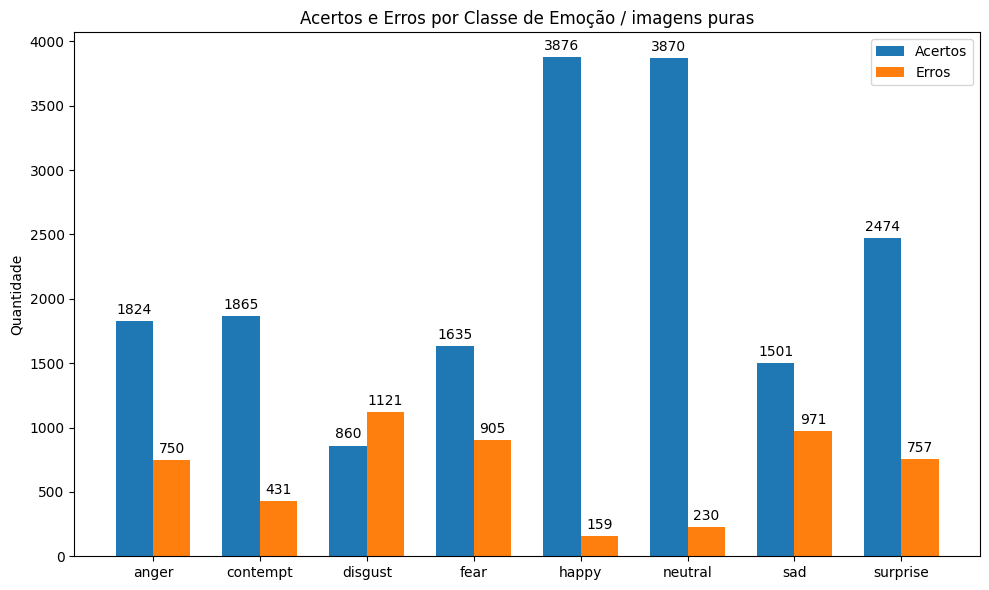

In [34]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Definir transformações para as imagens
image_size = 224  # Tamanho das imagens, ajuste conforme necessário
transformacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnet.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções de uma imagem
def prever_emocao(image_path):
    # Carregar a imagem
    imagem = Image.open(image_path).convert('RGB')
    
    # Aplicar as transformações
    imagem_transformada = transformacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        _, pred = torch.max(saida, 1)
        emocao_predita = classes[pred.item()]
    
    return emocao_predita

# Inicializar contadores de acertos e erros para cada classe
acertos_por_classe = {classe: 0 for classe in classes}
erros_por_classe = {classe: 0 for classe in classes}

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/affectnet/processed/imagens_processed/treino/'

# Loop para prever a emoção de cada imagem em cada pasta de classe
for classe in classes:
    pasta_imagens = os.path.join(base_dir, classe)
    
    for imagem_nome in os.listdir(pasta_imagens):
        caminho_imagem = os.path.join(pasta_imagens, imagem_nome)
        
        if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por arquivos de imagem
            emocao_predita = prever_emocao(caminho_imagem)
            
            if emocao_predita == classe:
                acertos_por_classe[classe] += 1
            else:
                erros_por_classe[classe] += 1

# Plotar gráfico de acertos e erros para cada classe
labels = list(classes)
acertos = [acertos_por_classe[classe] for classe in classes]
erros = [erros_por_classe[classe] for classe in classes]

x = np.arange(len(labels))  # Posições das labels
largura = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - largura/2, acertos, largura, label='Acertos')
rects2 = ax.bar(x + largura/2, erros, largura, label='Erros')

# Adicionar texto e labels
ax.set_ylabel('Quantidade')
ax.set_title('Acertos e Erros por Classe de Emoção / imagens puras')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    """Anexar valor nas barras"""
    for rect in rects:
        altura = rect.get_height()
        ax.annotate(f'{altura}',
                    xy=(rect.get_x() + rect.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_21336\1467080324.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

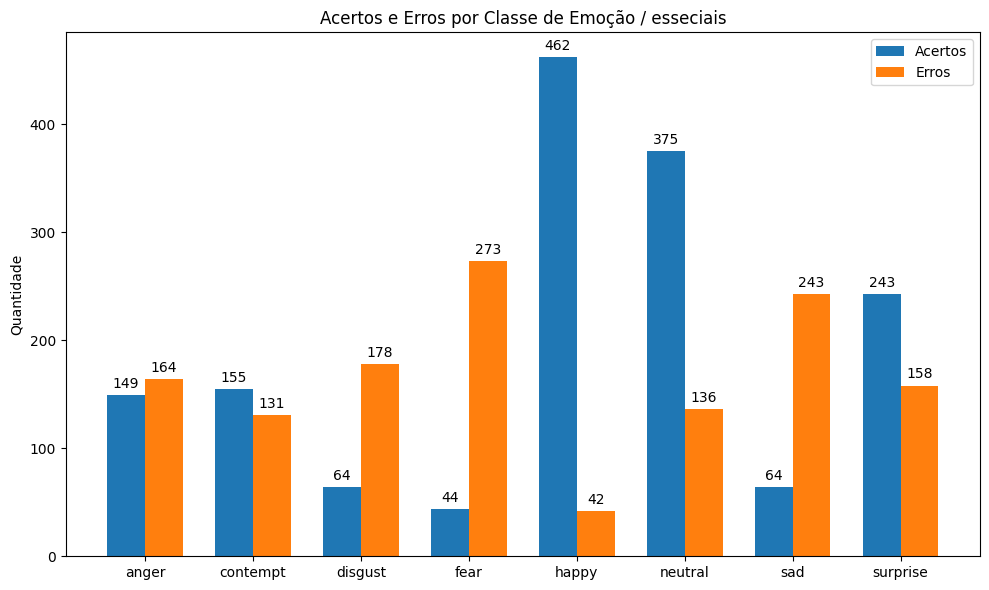

In [35]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Definir transformações para as imagens
image_size = 224  # Tamanho das imagens, ajuste conforme necessário
transformacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnetessenciais.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções de uma imagem
def prever_emocao(image_path):
    # Carregar a imagem
    imagem = Image.open(image_path).convert('RGB')
    
    # Aplicar as transformações
    imagem_transformada = transformacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        _, pred = torch.max(saida, 1)
        emocao_predita = classes[pred.item()]
    
    return emocao_predita

# Inicializar contadores de acertos e erros para cada classe
acertos_por_classe = {classe: 0 for classe in classes}
erros_por_classe = {classe: 0 for classe in classes}

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/affectnet/processed/essenciais/teste'

# Loop para prever a emoção de cada imagem em cada pasta de classe
for classe in classes:
    pasta_imagens = os.path.join(base_dir, classe)
    
    for imagem_nome in os.listdir(pasta_imagens):
        caminho_imagem = os.path.join(pasta_imagens, imagem_nome)
        
        if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por arquivos de imagem
            emocao_predita = prever_emocao(caminho_imagem)
            
            if emocao_predita == classe:
                acertos_por_classe[classe] += 1
            else:
                erros_por_classe[classe] += 1

# Plotar gráfico de acertos e erros para cada classe
labels = list(classes)
acertos = [acertos_por_classe[classe] for classe in classes]
erros = [erros_por_classe[classe] for classe in classes]

x = np.arange(len(labels))  # Posições das labels
largura = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - largura/2, acertos, largura, label='Acertos')
rects2 = ax.bar(x + largura/2, erros, largura, label='Erros')

# Adicionar texto e labels
ax.set_ylabel('Quantidade')
ax.set_title('Acertos e Erros por Classe de Emoção / esseciais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    """Anexar valor nas barras"""
    for rect in rects:
        altura = rect.get_height()
        ax.annotate(f'{altura}',
                    xy=(rect.get_x() + rect.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_21336\3125183623.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

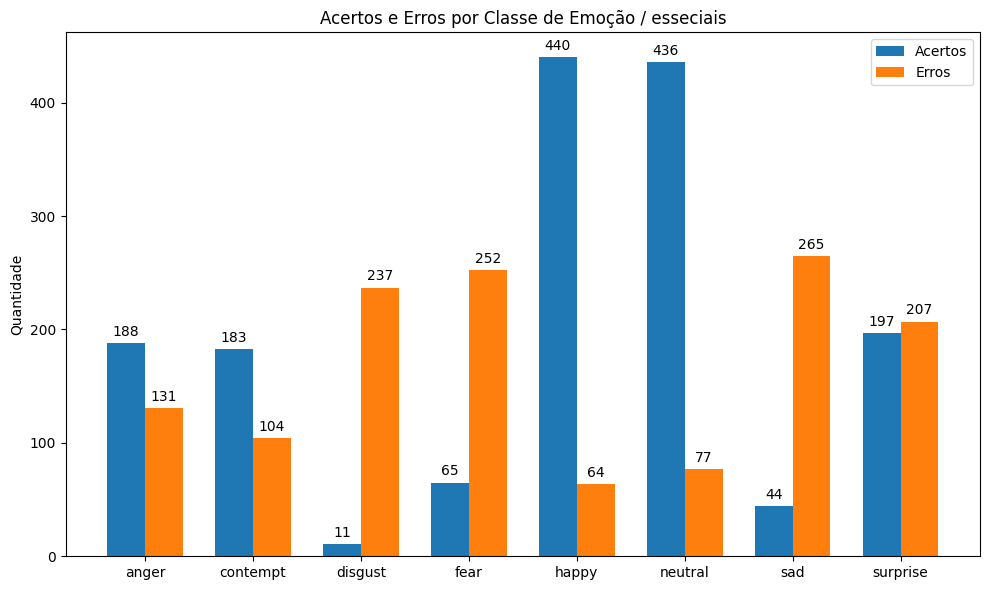

In [36]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Definir transformações para as imagens
image_size = 224  # Tamanho das imagens, ajuste conforme necessário
transformacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnetlandmarks.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções de uma imagem
def prever_emocao(image_path):
    # Carregar a imagem
    imagem = Image.open(image_path).convert('RGB')
    
    # Aplicar as transformações
    imagem_transformada = transformacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        _, pred = torch.max(saida, 1)
        emocao_predita = classes[pred.item()]
    
    return emocao_predita

# Inicializar contadores de acertos e erros para cada classe
acertos_por_classe = {classe: 0 for classe in classes}
erros_por_classe = {classe: 0 for classe in classes}

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/affectnet/processed/landmarks/teste'

# Loop para prever a emoção de cada imagem em cada pasta de classe
for classe in classes:
    pasta_imagens = os.path.join(base_dir, classe)
    
    for imagem_nome in os.listdir(pasta_imagens):
        caminho_imagem = os.path.join(pasta_imagens, imagem_nome)
        
        if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por arquivos de imagem
            emocao_predita = prever_emocao(caminho_imagem)
            
            if emocao_predita == classe:
                acertos_por_classe[classe] += 1
            else:
                erros_por_classe[classe] += 1

# Plotar gráfico de acertos e erros para cada classe
labels = list(classes)
acertos = [acertos_por_classe[classe] for classe in classes]
erros = [erros_por_classe[classe] for classe in classes]

x = np.arange(len(labels))  # Posições das labels
largura = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - largura/2, acertos, largura, label='Acertos')
rects2 = ax.bar(x + largura/2, erros, largura, label='Erros')

# Adicionar texto e labels
ax.set_ylabel('Quantidade')
ax.set_title('Acertos e Erros por Classe de Emoção / esseciais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    """Anexar valor nas barras"""
    for rect in rects:
        altura = rect.get_height()
        ax.annotate(f'{altura}',
                    xy=(rect.get_x() + rect.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


C:\Users\Danil\AppData\Local\Temp\ipykernel_21336\751208555.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  estado_do_modelo = torch.load('../models/model2affectnetfull

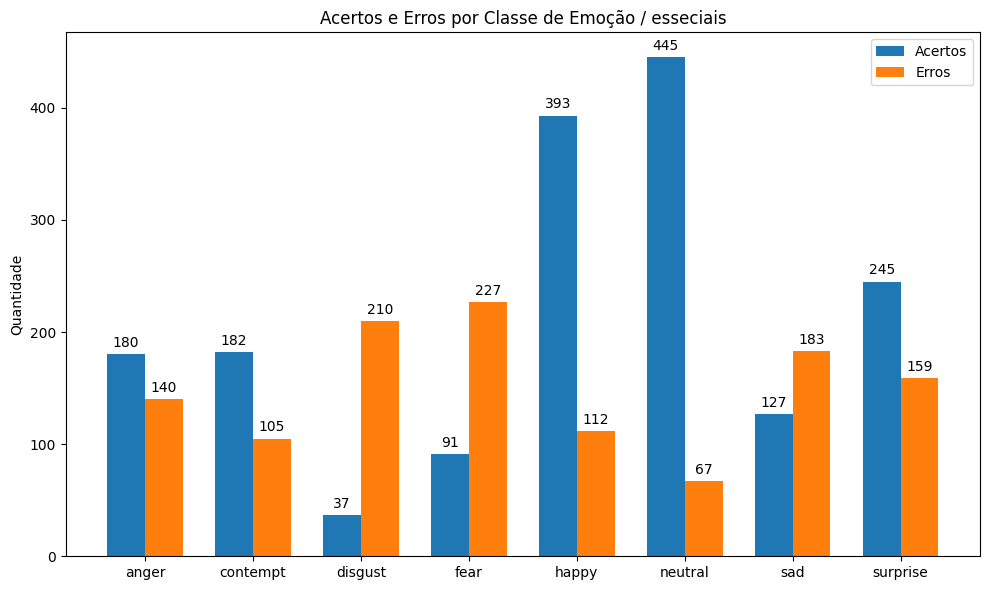

In [77]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Definir transformações para as imagens
image_size = 224  # Tamanho das imagens, ajuste conforme necessário
transformacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnetfullconected.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções de uma imagem
def prever_emocao(image_path):
    # Carregar a imagem
    imagem = Image.open(image_path).convert('RGB')
    
    # Aplicar as transformações
    imagem_transformada = transformacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        _, pred = torch.max(saida, 1)
        emocao_predita = classes[pred.item()]
    
    return emocao_predita

# Inicializar contadores de acertos e erros para cada classe
acertos_por_classe = {classe: 0 for classe in classes}
erros_por_classe = {classe: 0 for classe in classes}

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/affectnet/processed/landmarksConected/teste'

# Loop para prever a emoção de cada imagem em cada pasta de classe
for classe in classes:
    pasta_imagens = os.path.join(base_dir, classe)
    
    for imagem_nome in os.listdir(pasta_imagens):
        caminho_imagem = os.path.join(pasta_imagens, imagem_nome)
        
        if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por arquivos de imagem
            emocao_predita = prever_emocao(caminho_imagem)
            
            if emocao_predita == classe:
                acertos_por_classe[classe] += 1
            else:
                erros_por_classe[classe] += 1

# Plotar gráfico de acertos e erros para cada classe
labels = list(classes)
acertos = [acertos_por_classe[classe] for classe in classes]
erros = [erros_por_classe[classe] for classe in classes]

x = np.arange(len(labels))  # Posições das labels
largura = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - largura/2, acertos, largura, label='Acertos')
rects2 = ax.bar(x + largura/2, erros, largura, label='Erros')

# Adicionar texto e labels
ax.set_ylabel('Quantidade')
ax.set_title('Acertos e Erros por Classe de Emoção / esseciais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    """Anexar valor nas barras"""
    for rect in rects:
        altura = rect.get_height()
        ax.annotate(f'{altura}',
                    xy=(rect.get_x() + rect.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_23468\1907757408.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

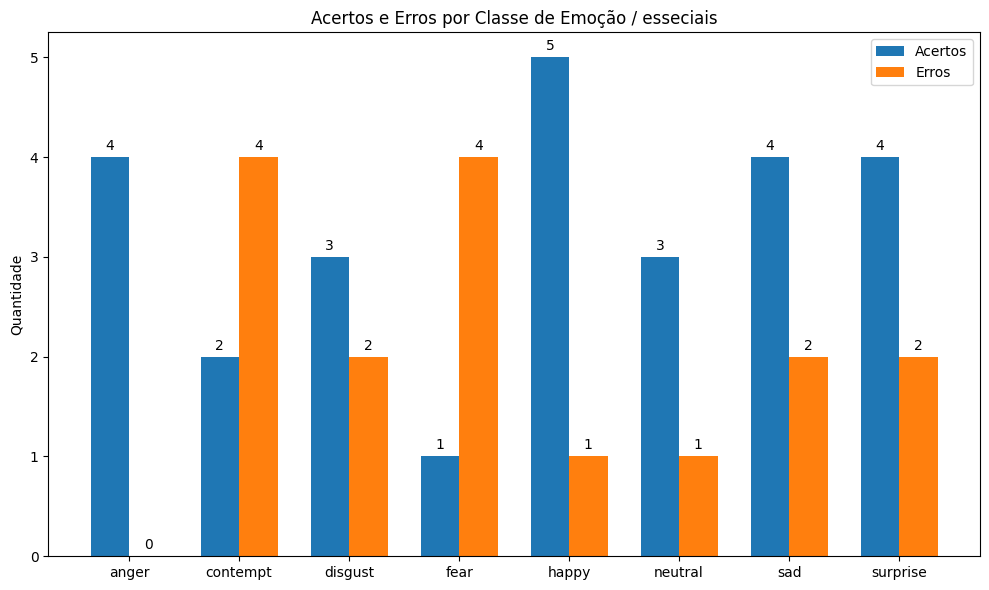

In [14]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Definir transformações para as imagens
image_size = 224  # Tamanho das imagens, ajuste conforme necessário
transformacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnet.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções de uma imagem
def prever_emocao(image_path):
    # Carregar a imagem
    imagem = Image.open(image_path).convert('RGB')
    
    # Aplicar as transformações
    imagem_transformada = transformacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        _, pred = torch.max(saida, 1)
        emocao_predita = classes[pred.item()]
    
    return emocao_predita

# Inicializar contadores de acertos e erros para cada classe
acertos_por_classe = {classe: 0 for classe in classes}
erros_por_classe = {classe: 0 for classe in classes}

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/net/imagens_processed/teste/'

# Loop para prever a emoção de cada imagem em cada pasta de classe
for classe in classes:
    pasta_imagens = os.path.join(base_dir, classe)
    
    for imagem_nome in os.listdir(pasta_imagens):
        caminho_imagem = os.path.join(pasta_imagens, imagem_nome)
        
        if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por arquivos de imagem
            emocao_predita = prever_emocao(caminho_imagem)
            
            if emocao_predita == classe:
                acertos_por_classe[classe] += 1
            else:
                erros_por_classe[classe] += 1

# Plotar gráfico de acertos e erros para cada classe
labels = list(classes)
acertos = [acertos_por_classe[classe] for classe in classes]
erros = [erros_por_classe[classe] for classe in classes]

x = np.arange(len(labels))  # Posições das labels
largura = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - largura/2, acertos, largura, label='Acertos')
rects2 = ax.bar(x + largura/2, erros, largura, label='Erros')

# Adicionar texto e labels
ax.set_ylabel('Quantidade')
ax.set_title('Acertos e Erros por Classe de Emoção / esseciais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    """Anexar valor nas barras"""
    for rect in rects:
        altura = rect.get_height()
        ax.annotate(f'{altura}',
                    xy=(rect.get_x() + rect.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


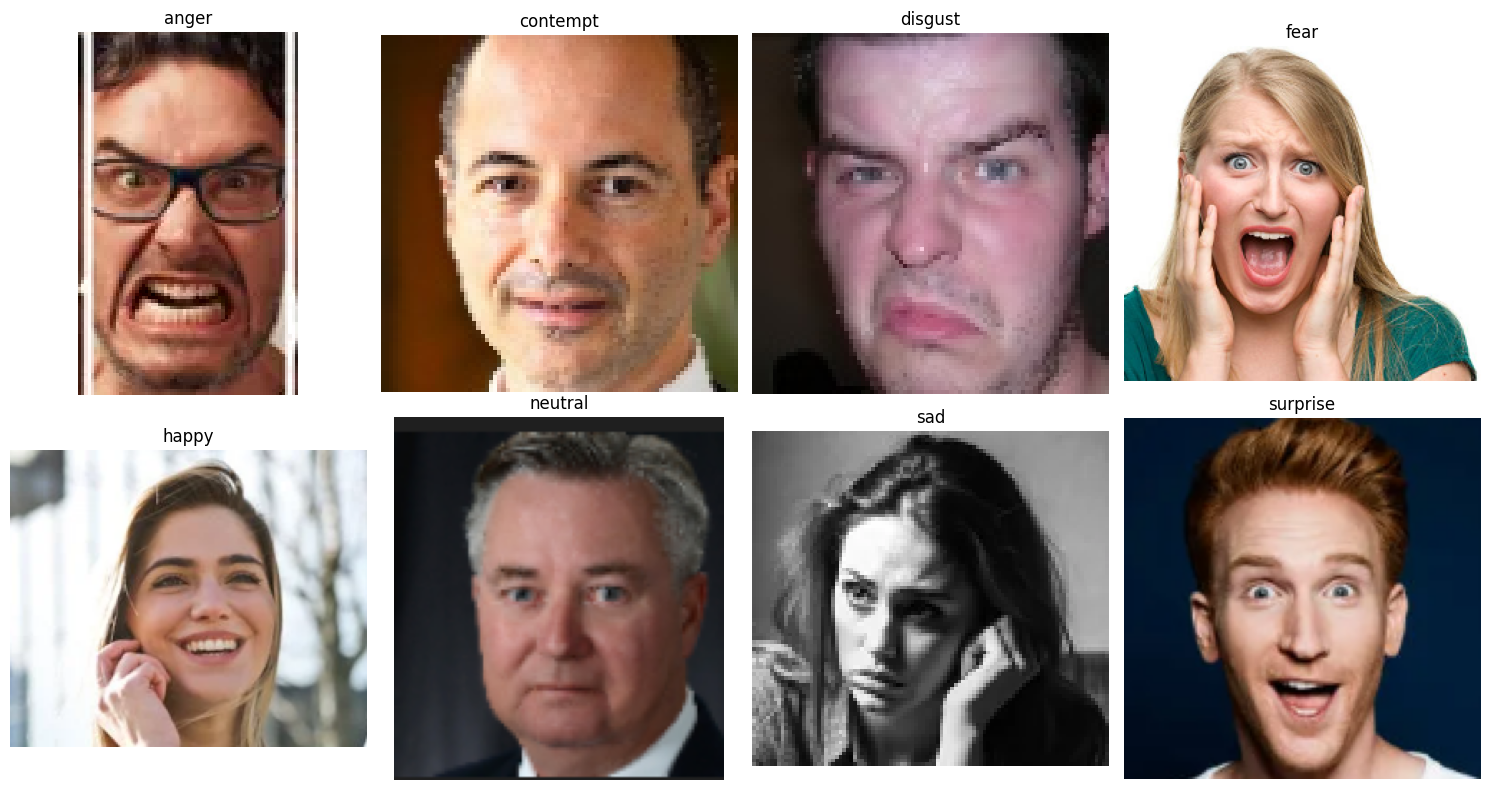

In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Diretório base onde estão as imagens organizadas por classe
base_dir = '../data/net/imagens_processed/teste/'  # Ajuste o caminho aqui
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Função para exibir uma imagem por classe
def mostrar_imagens_de_cada_classe(base_dir, classes):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Configuração de subplots
    axes = axes.ravel()  # Para fácil indexação

    for i, classe in enumerate(classes):
        pasta_imagens = os.path.join(base_dir, classe)
        
        # Verifica se a pasta existe e possui imagens
        if os.path.exists(pasta_imagens) and os.listdir(pasta_imagens):
            imagem_nome = os.listdir(pasta_imagens)[0]  # Pegar a primeira imagem da classe
            caminho_imagem = os.path.join(pasta_imagens, imagem_nome)

            if caminho_imagem.endswith(('.png', '.jpg', '.jpeg')):  # Verificar se é uma imagem válida
                imagem = Image.open(caminho_imagem)
                axes[i].imshow(imagem)
                axes[i].set_title(classe)
                axes[i].axis('off')  # Remover eixos
        else:
            axes[i].set_title(f"{classe} (Sem imagem)")
            axes[i].axis('off')  # Remover eixos

    plt.tight_layout()
    plt.show()

# Mostrar imagens
mostrar_imagens_de_cada_classe(base_dir, classes)

In [75]:
import os
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Definir transformações para as imagens (mesmas usadas na fase de validação durante o treino)
image_size = 224  # Defina o tamanho da imagem se ainda não definido
transformacao_validacao = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definir classes de emoção
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'não identificado']

# Configurações de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo treinado
modelo_treinado = CustomResNet50(8).get_model()  # Obtenha o modelo PyTorch dentro da classe

# Carregar os pesos salvos do modelo
estado_do_modelo = torch.load('../models/model2affectnet.pt', map_location=device)
modelo_treinado.load_state_dict(estado_do_modelo)  # Carregar os pesos no modelo PyTorch
modelo_treinado.to(device)

# Colocar o modelo em modo de avaliação
modelo_treinado.eval()

# Função para prever emoções e retornar as probabilidades de cada emoção
def prever_emocao_frame(frame):
    # Converter a imagem do frame capturado
    imagem = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Aplicar as transformações (mesmas usadas durante a validação)
    imagem_transformada = transformacao_validacao(imagem).unsqueeze(0).to(device)  # Adicionar dimensão de batch
    
    # Fazer a predição
    with torch.no_grad():
        saida = modelo_treinado(imagem_transformada)
        probabilidades = torch.softmax(saida, dim=1)  # Calcular probabilidades para todas as classes
        return probabilidades.cpu().numpy()[0]  # Retorna as probabilidades de todas as classes

# Função para exibir as probabilidades das emoções no feed de vídeo
def exibir_probabilidades(frame, probabilidades):
    # Definir a posição inicial para exibir as emoções
    y_inicial = 30
    step = 30

    # Encontrar a classe com a maior probabilidade
    maior_indice = np.argmax(probabilidades)

    # Exibir as probabilidades acima de 20% e "não identificado" se nenhuma emoção tiver > 20%
    identificada = False
    for i, prob in enumerate(probabilidades):
        if prob * 100 >= 30:
            identificada = True
            texto = f'{classes[i]}: {prob*100:.2f}%'
            # Se for a maior probabilidade, usar cor vermelha, senão usar branco
            cor = (0, 0, 255) if i == maior_indice else (255, 255, 255)
            cv2.putText(frame, texto, (10, y_inicial + i * step), cv2.FONT_HERSHEY_SIMPLEX, 0.7, cor, 2, cv2.LINE_AA)

    # Se nenhuma emoção tiver probabilidade acima de 20%, exibir "Não identificado"
    if not identificada:
        cv2.putText(frame, 'Não identificado', (10, y_inicial), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

# Inicializar a captura de vídeo da câmera
camera = cv2.VideoCapture(0)  # 0 geralmente corresponde à câmera padrão

if not camera.isOpened():
    print("Erro ao acessar a câmera.")
else:
    while True:
        # Ler um frame da câmera
        ret, frame = camera.read()
        
        if not ret:
            print("Falha ao capturar o frame.")
            break
        
        # Prever as probabilidades das emoções no frame capturado
        probabilidades = prever_emocao_frame(frame)
        
        # Exibir as probabilidades no feed de vídeo
        exibir_probabilidades(frame, probabilidades)
        
        # Exibir o frame com as probabilidades de emoções
        cv2.imshow('Previsao de Emoção em Tempo Real', frame)
        
        # Parar a execução ao pressionar 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Liberar a câmera e fechar as janelas
camera.release()
cv2.destroyAllWindows()


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_21336\2844952490.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

Erro ao acessar a câmera.
